# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, n_classes, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize,
        labels=range(n_classes)
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [18]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

100%|██████████| 170498071/170498071 [00:13<00:00, 13083584.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [19]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

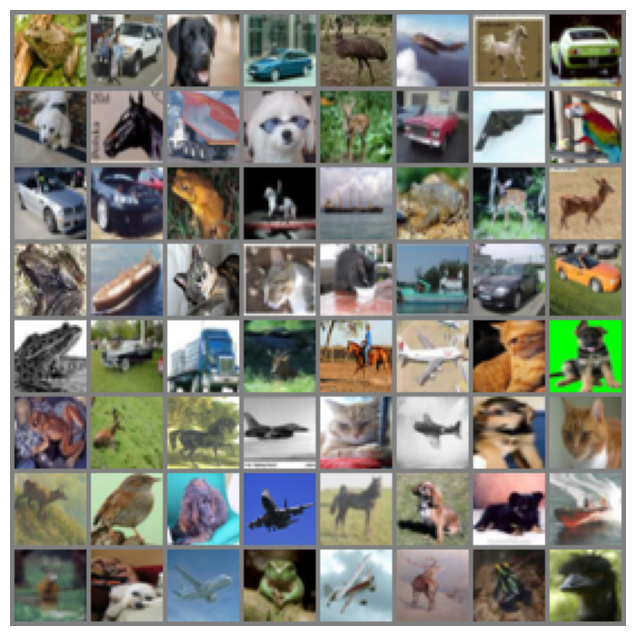

In [20]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network.
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [21]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class ConvModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv_net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(20*16*16, num_classes)
        )

    def forward(self, x):
        x = self.conv_net(x)
        return x

class ConvModelDeep (nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv_net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(128*16*16, num_classes)
        )

    def forward(self, x):
        x = self.conv_net(x)
        return x

device = torch.device('cuda')  # use cuda or cpu

model = ConvModel(n_classes)
model.to(device)
print(model)

deep_model = ConvModelDeep(n_classes)
deep_model.to(device)
print(deep_model)

ConvModel(
  (conv_net): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=5120, out_features=10, bias=True)
  )
)
ConvModelDeep(
  (conv_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train the network

**Assignment 3:** Finish the training loop below.
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [23]:
# Test the forward pass with dummy data
out = deep_model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.07667462  0.34706935 -1.6843691   0.00632123  0.95501655  0.14180672
   0.29017615 -0.19348294 -0.67527163 -0.13180529]
 [ 0.4025083   0.23805748  0.36639598 -0.35551047 -0.28330597 -0.14115767
  -0.68575794 -0.48151731 -0.8954177   0.10030371]]
Output probabilities:
[[0.08551809 0.13064346 0.01713346 0.0929186  0.23994726 0.10640039
  0.12341822 0.07609021 0.04699922 0.08093104]
 [0.16318585 0.13844028 0.15739797 0.0764679  0.08219344 0.0947483
  0.05496098 0.06741478 0.04456567 0.12062484]]


In [24]:
def training_loop(torch_model, num_epochs, loss_fn, optimizer):
  train_accuracies = []
  valid_accuracies = []

  validation_every_steps = 500

  step = 0

  torch_model.train()
  for epoch in range(num_epochs):

      train_accuracies_batches = []

      for inputs, targets in train_loader:
          inputs, targets = inputs.to(device), targets.to(device)

          # Forward pass
          output = torch_model(inputs)

          # Compute loss
          loss = loss_fn(output, targets)

          # Reset gradients
          optimizer.zero_grad()

          # Compute gradients
          loss.backward()

          # Adjust parameters
          optimizer.step()

          # Increment step counter
          step += 1

          # Compute accuracy.
          predictions = output.max(1)[1]
          train_accuracies_batches.append(accuracy(targets, predictions))

          if step % validation_every_steps == 0:

              # Append average training accuracy to list.
              train_accuracies.append(np.mean(train_accuracies_batches))

              train_accuracies_batches = []

              # Compute accuracies on validation set.
              valid_accuracies_batches = []
              with torch.no_grad():
                  torch_model.eval()
                  for inputs, targets in test_loader:
                      inputs, targets = inputs.to(device), targets.to(device)
                      output = torch_model(inputs)
                      loss = loss_fn(output, targets)

                      predictions = output.max(1)[1]

                      # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                      valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                  torch_model.train()

              # Append average validation accuracy to list.
              valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

              print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
              print(f"             test accuracy: {valid_accuracies[-1]}")

  print("Finished training.")


loss_fn_ce = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(deep_model.parameters(), lr=0.002, weight_decay=0.0001)

training_loop(deep_model, num_epochs=6, optimizer=optimizer_adam, loss_fn=loss_fn_ce)

Step 500     training accuracy: 0.42165625
             test accuracy: 0.5811
Step 1000    training accuracy: 0.6498709862385321
             test accuracy: 0.6575
Step 1500    training accuracy: 0.67015625
             test accuracy: 0.6914
Step 2000    training accuracy: 0.716026376146789
             test accuracy: 0.7021
Step 2500    training accuracy: 0.7540584415584416
             test accuracy: 0.7248
Step 3000    training accuracy: 0.74659375
             test accuracy: 0.7286
Step 3500    training accuracy: 0.7838961693548387
             test accuracy: 0.7327
Step 4000    training accuracy: 0.8152777777777778
             test accuracy: 0.7376
Step 4500    training accuracy: 0.7961875
             test accuracy: 0.7348
Finished training.


In [25]:
loss_fn_ce = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(deep_model.parameters(), lr=0.002, weight_decay=0.0001)

training_loop(deep_model, num_epochs=6, optimizer=optimizer_adam, loss_fn=loss_fn_ce)

Step 500     training accuracy: 0.80321875
             test accuracy: 0.755
Step 1000    training accuracy: 0.8430332568807339
             test accuracy: 0.7604
Step 1500    training accuracy: 0.8150625
             test accuracy: 0.7498
Step 2000    training accuracy: 0.8494839449541285
             test accuracy: 0.7402
Step 2500    training accuracy: 0.8813920454545454
             test accuracy: 0.7666
Step 3000    training accuracy: 0.85171875
             test accuracy: 0.7616
Step 3500    training accuracy: 0.8735719086021505
             test accuracy: 0.7612
Step 4000    training accuracy: 0.8897569444444444
             test accuracy: 0.7735
Step 4500    training accuracy: 0.874
             test accuracy: 0.7569
Finished training.


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

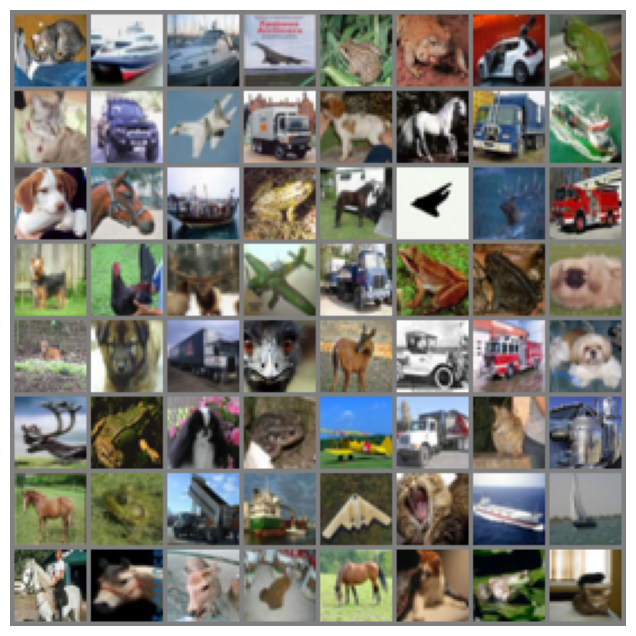

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          deer     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer        airplane   
    truck         truck    
     dog          deer     
    bird          bird     
    deer           dog     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           d

In [29]:
def show_predictions(torch_model, dataloader_obj):
  torch_model.eval()
  inputs, targets = next(iter(dataloader_obj))
  inputs, targets = inputs.to(device), targets.to(device)
  show_image(make_grid(inputs))
  plt.show()

  outputs = torch_model(inputs)
  _, predicted = torch.max(outputs.data, 1)

  print("    TRUE        PREDICTED")
  print("-----------------------------")
  for target, pred in zip(targets, predicted):
      print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")

show_predictions(deep_model, test_loader)


We now evaluate the network as above, but on the entire test set.

In [30]:
# Evaluate test set

confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    deep_model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = deep_model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        confusion_matrix += compute_confusion_matrix(targets, predictions, n_classes=n_classes)

    test_accuracy = np.sum(test_accuracies) / len(test_set)

    deep_model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [31]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.770


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


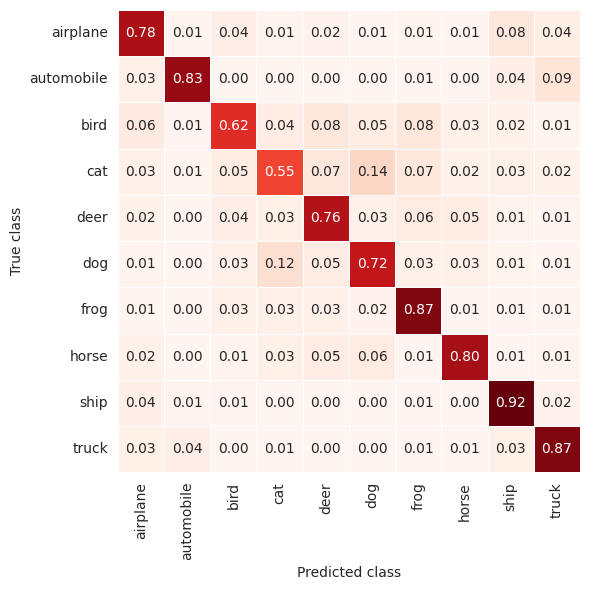

In [32]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

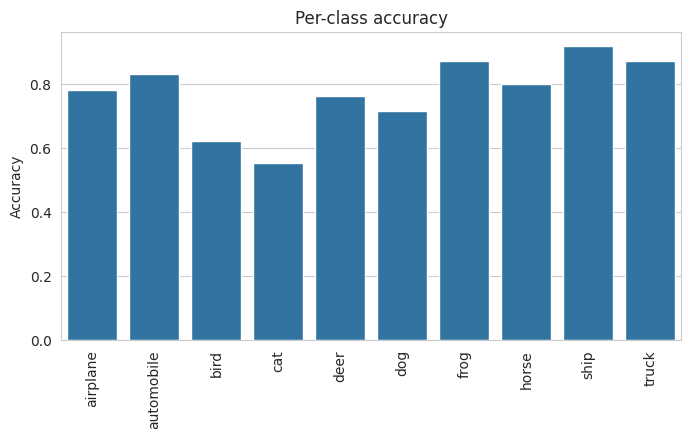

In [33]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:**
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**
1. I added additional conv layers, for the first convolutions I decided not to add pooling as I was afraid the 'resolution' would drop too much early on. I googled a bit on heuristics in terms of features, and found that it was recomended to ramp up features, rather than down, hence I did the increase from 32, to 64, to 128.
2. I got the 70% accuracy in first go after running 2 epochs with my slightly deeper conv. I then increased training to 6 epochs, but started seing overfitting, with a low train loss but stagnant validation loss as seen below,

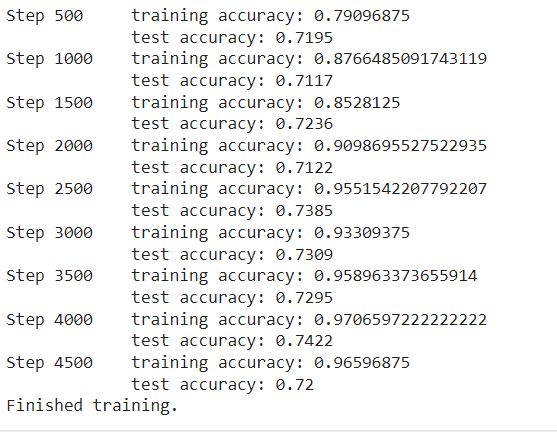

3.

To reduce the risk of overfitting, I added a dropout of 50% in the final hidden layer, and added weight decay to the optimizer.

With those adjustments, I was able to get 77,0% accuracy as seen from the test accuracy further up.

3. LearningsNN arcitecture seems very difficult, if almost random, to decide on. I 'randomly' chose one arcitecture for the above experiment which worked fine, but I currently have no idea of how 1 of the 1000 other layer combinations could be better. I can see how hyperparameters can "easily" be explored with a variation of grid search, but adding the variable of the architecture itself seems to make the problem very complex :-)

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [11]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['Tesla T4']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





**Exercise from Chapter 6, deep learning**

What classification accuracy do you get if you omit the fully-connected layer, and just use the convolutional-pooling layer and softmax layer? Does the inclusion of the fully-connected layer help?

*For reference, the book mentions that the below network gets 98.78% accuracy*

```python
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28),
                      filter_shape=(20, 1, 5, 5),
                      poolsize=(2, 2)),
        FullyConnectedLayer(n_in=20*12*12, n_out=100),
        SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)
net.SGD(training_data, 60, mini_batch_size, 0.1,
            validation_data, test_data)
```

**Step 1** Recreating the reference NN architecture from Michael Nielsens Book in Torch

In [6]:
class ConvModelBook (nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv_net = nn.Sequential(
            #conv w/o padding and kernel 5, reduces input size from 28 to 24
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
            #Max pool w. kernel 2, reduces dim from 24x24 to 12x12
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),  # Add a flatten layer to reshape the output before Linear
            nn.Linear(in_features=20*12*12, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=num_classes)
        )

    def forward(self, x):
        x = self.conv_net(x)
        return x

device = torch.device('cuda')  # use cuda or cpu

conv_model_book = ConvModelBook(num_classes=10)
conv_model_book.to(device)
print(conv_model_book)

ConvModelBook(
  (conv_net): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=2880, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


Loading the MNIST dataset

In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Load the datasets with transformations
mnist_trainset = MNIST("./temp/", train=True, download=True, transform=transform)
mnist_testset = MNIST("./temp/", train=False, download=True, transform=transform)

# Create subsets
train_indices = range(0, 50000)
valid_indices = range(50000, 60000)
test_indices = range(0, 10000)

train_set = Subset(mnist_trainset, train_indices)
valid_set = Subset(mnist_trainset, valid_indices)
test_set = Subset(mnist_testset, test_indices)

# Create DataLoader instances
batch_size = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5086479.84it/s]


Extracting ./temp/MNIST/raw/train-images-idx3-ubyte.gz to ./temp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 57439.03it/s]


Extracting ./temp/MNIST/raw/train-labels-idx1-ubyte.gz to ./temp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1259311.17it/s]


Extracting ./temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./temp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10923468.33it/s]

Extracting ./temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./temp/MNIST/raw



Slight modification of the previous NN training function
> primary difference, added early stopping so that the training stops if validation loss has not increased in the past N epochs.

In [12]:
def training_loop(torch_model, num_epochs, loss_fn, optimizer):
  train_accuracies = []
  valid_accuracies = []

  epochs_without_improvement = 0
  best_val_loss = float('inf')
  early_stopping_patience = 3

  for epoch in range(num_epochs):
      torch_model.train()
      train_accuracies_batches = []

      for inputs, targets in train_loader:
          inputs, targets = inputs.to(device), targets.to(device)

          # Forward pass
          output = torch_model(inputs)

          # Compute loss
          loss = loss_fn(output, targets)

          # Reset gradients
          optimizer.zero_grad()

          # Compute gradients
          loss.backward()

          # Adjust parameters
          optimizer.step()

      torch_model.eval()
      val_loss = 0
      correct = 0
      with torch.no_grad():
          for inputs, target in valid_loader:
              inputs, target = inputs.to(device), target.to(device)
              output = torch_model(inputs)
              val_loss += loss_fn(output, target).item()
              pred = output.argmax(dim=1, keepdim=True)
              correct += pred.eq(target.view_as(pred)).sum().item()

      val_loss /= len(valid_loader.dataset)
      accuracy = 100. * correct / len(valid_loader.dataset)
      print(f'Epoch {epoch+1},Accuracy: {accuracy:.2f}%, Validation loss: {val_loss:.4f}')

      #Early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= early_stopping_patience:
              print("Early stopping")
              break

  print("Finished training.")

In [10]:
def test_eval(model, test_loader, loss_fn):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for inputs, target in test_loader:
          inputs, target = inputs.to(device), target.to(device)
          output = model(inputs)
          test_loss += loss_fn(output, target).item()
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')


Train the network and calculate the referece accuracy: In the book, 98.4% is stated as the reference.

In [13]:
loss_fn_ce = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(conv_model_book.parameters(), lr=0.1)
epochs=60

training_loop(conv_model_book, num_epochs=epochs, optimizer=optimizer_SGD, loss_fn=loss_fn_ce)

Epoch 1,Accuracy: 98.68%, Validation loss: 0.0058
Epoch 2,Accuracy: 98.60%, Validation loss: 0.0065
Epoch 3,Accuracy: 98.47%, Validation loss: 0.0081
Epoch 4,Accuracy: 98.85%, Validation loss: 0.0065
Early stopping
Finished training.


In [11]:
test_eval(conv_model_book, test_loader, loss_fn_ce)

Test Loss: 0.0052, Accuracy: 98.54%


In this case our test loss is 98.5%, close enough to the book reference.
Now let's see how removing the FC layer affects training and results.

In [14]:
class ConvModelBook_wo_fc (nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv_net = nn.Sequential(
            #conv w/o padding and kernel 5, reduces input size from 28 to 24
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
            #Max pool w. kernel 2, reduces dim from 24x24 to 12x12
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),  # Add a flatten layer to reshape the output before Linear
            nn.Linear(in_features=20*12*12, out_features=num_classes)
        )

    def forward(self, x):
        x = self.conv_net(x)
        return x

device = torch.device('cuda')  # use cuda or cpu

conv_model_book_wo_fc = ConvModelBook(num_classes=10)
conv_model_book_wo_fc.to(device)
print(conv_model_book_wo_fc)

ConvModelBook(
  (conv_net): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=2880, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [15]:
loss_fn_ce = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(conv_model_book_wo_fc.parameters(), lr=0.1)
epochs=60

training_loop(conv_model_book_wo_fc, num_epochs=epochs, optimizer=optimizer_SGD, loss_fn=loss_fn_ce)

Epoch 1,Accuracy: 98.03%, Validation loss: 0.0072
Epoch 2,Accuracy: 98.29%, Validation loss: 0.0065
Epoch 3,Accuracy: 98.52%, Validation loss: 0.0055
Epoch 4,Accuracy: 98.53%, Validation loss: 0.0059
Epoch 5,Accuracy: 98.60%, Validation loss: 0.0063
Epoch 6,Accuracy: 98.51%, Validation loss: 0.0069
Early stopping
Finished training.


In [16]:
test_eval(conv_model_book_wo_fc, test_loader, loss_fn_ce)

Test Loss: 0.0058, Accuracy: 98.63%


**Conclusion**
As seen from the results, both networks achieve fairly similar performance, the latter without the fully connected layer ends up with ~0.1% better performance on the test set. It does however seem like the no_fc model takes more steps to learn and achieve the same validation loss. This could be because the lack of a fully connnected layer essentially simplifies the model, indirectly acting as a type of regularization, making it harder for the model to learn the patterns, but also less prone to overfitting the training data. Anothe argument for why omitting the FC could be beneficial, is that the FC layer essentially flatens and looses the spatial representation from the conv layer, so not having it might be beneficial for the final layer prediction.